# Generate Input Data

In [1]:
import numpy as np
import pandas as pd
import random
#Generate 5 random numbers between 10 and 30
np.random.seed(0)
n_samples=1000
n_features = 5
df_XY=pd.DataFrame(data = np.random.normal(0,1, size=(n_samples, n_features)), columns = ['A','B','C','D','E'])
df_XY['Y']=list(np.random.randint(2, size=n_samples))
df_XY['YY']=list(np.random.randint(2, size=n_samples))
df_XY

##############################################################   
df_XY.shape
df_XY.head()
df_XY.to_csv('df_XY.csv',index=False)
##############################################################

In [2]:
df_XY

,A,B,C,D,E,Y,YY
0,1.764052,0.400157,0.978738,2.240893,1.867558,1,1
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,0,0
2,0.144044,1.454274,0.761038,0.121675,0.443863,0,0
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1,0
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0,1
...,...,...,...,...,...,...,...
995,1.711489,-1.820816,0.163495,-0.813117,-0.605355,0,0
996,-1.327524,-0.644172,1.908883,-0.563545,1.082473,1,0
997,-1.951911,2.441216,-0.017285,0.912282,1.239658,1,1
998,-0.573367,0.424889,-0.271260,-0.683568,-1.537438,1,1


# Download CI-VAE, other necessary packages and Load Packages

In [3]:
! rm -rf ci_vae
! rm bb.pt
! rm bb_residuals.pkl
! rm df_reconstructed.csv
! rm df_reconstructed_decoder.csv
! rm residuals.pdf
! rm results_dict.pkl
! rm df_latent.csv

rm: df_reconstructed.csv: No such file or directory
rm: df_reconstructed_decoder.csv: No such file or directory
rm: results_dict.pkl: No such file or directory
rm: df_latent.csv: No such file or directory


In [4]:
! git clone https://github.com/monabiyan/ci_vae.git
! pip install umap-learn

Cloning into 'ci_vae'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 349 (delta 53), reused 77 (delta 27), pack-reused 245
Receiving objects: 100% (349/349), 47.32 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [6]:
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle

In [ ]:
#import umap

In [7]:
import matplotlib.pyplot as plt
from ci_vae import ivae

# Set Necessary Parameters 

In [9]:
model_init=True
model_tobe_trained=True
save_address="bb"

kl_coef = 0.0001
reconst_coef = 1
classifier_coef = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Initialize the Model

In [10]:
obj1 = ivae.IVAE(df_XY = df_XY,
               latent_size = 10,
               reconst_coef = reconst_coef,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

if model_init:
    obj1.model_initialiaze()

## See The Model Architecture

In [11]:
print(obj1.model)

IVAE_ARCH(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (15): Dropout(p=0.05, inplace=False)
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=Tru

## See the Initialized Weights

In [12]:
for param in obj1.model.parameters():
    print(param)

Parameter containing:
tensor([[-0.1424,  0.0664, -0.0965,  0.1646,  0.2640],
        [-0.0476,  0.3125,  0.3737, -0.1541, -0.1036],
        [ 0.1287, -0.0847, -0.1403,  0.4251,  0.2863],
        [-0.4365,  0.3215,  0.3000,  0.0955,  0.4236],
        [-0.0062, -0.2413,  0.0304, -0.0109,  0.0527],
        [ 0.4258,  0.3198,  0.0723,  0.2268, -0.1648],
        [ 0.0251, -0.3015,  0.0916, -0.0205, -0.4170],
        [ 0.2164, -0.3819,  0.1006, -0.4042, -0.1077],
        [ 0.3434, -0.0119, -0.3739,  0.4114,  0.0953],
        [ 0.2157,  0.1486, -0.0704,  0.4245,  0.0029],
        [ 0.3339,  0.2354, -0.1250, -0.0008,  0.2527],
        [-0.2057,  0.0031, -0.4050,  0.3786, -0.2125],
        [ 0.2136, -0.1749, -0.3011,  0.2325, -0.3028],
        [-0.1992, -0.2421, -0.3499,  0.1653, -0.0067],
        [ 0.2618, -0.2680,  0.0324,  0.1459,  0.4336],
        [ 0.3962,  0.1804,  0.4054,  0.3693, -0.3493],
        [-0.1669,  0.1923, -0.4162,  0.0365,  0.4081],
        [ 0.4469, -0.1421,  0.1284, -0.2480

# RUN for Training

In [13]:
##########
if model_tobe_trained:
    lr=1e-2
    print(lr)
    obj1.model_training(epochs=100,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=200,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')
    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')

    lr=1e-5
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    lr=5e-6
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)


0.01
====> Epoch: 1 total_train_loss: 1.000880 Total_test_loss: 0.870857 Total_BCE_test_loss: 0.793625 Total_KLD_test_loss: 0.000060 Total_CEP_test_loss: 0.077172


/Users/mohsennabian/Desktop/ci_vae/example/ci_vae/ivae.py:372: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
/Users/mohsennabian/Desktop/ci_vae/example/ci_vae/ivae.py:400: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


====> Epoch: 2 total_train_loss: 0.936869 Total_test_loss: 0.867478 Total_BCE_test_loss: 0.790890 Total_KLD_test_loss: 0.000061 Total_CEP_test_loss: 0.076527
====> Epoch: 3 total_train_loss: 0.915077 Total_test_loss: 0.862164 Total_BCE_test_loss: 0.789154 Total_KLD_test_loss: 0.000076 Total_CEP_test_loss: 0.072934
====> Epoch: 4 total_train_loss: 0.906228 Total_test_loss: 0.862140 Total_BCE_test_loss: 0.788404 Total_KLD_test_loss: 0.000116 Total_CEP_test_loss: 0.073620
====> Epoch: 5 total_train_loss: 0.903028 Total_test_loss: 0.862206 Total_BCE_test_loss: 0.788800 Total_KLD_test_loss: 0.000183 Total_CEP_test_loss: 0.073223
====> Epoch: 6 total_train_loss: 0.884127 Total_test_loss: 0.860501 Total_BCE_test_loss: 0.788520 Total_KLD_test_loss: 0.000245 Total_CEP_test_loss: 0.071736
====> Epoch: 7 total_train_loss: 0.878501 Total_test_loss: 0.861922 Total_BCE_test_loss: 0.789539 Total_KLD_test_loss: 0.000269 Total_CEP_test_loss: 0.072114
====> Epoch: 8 total_train_loss: 0.874775 Total_test

====> Epoch: 56 total_train_loss: 0.732513 Total_test_loss: 0.708396 Total_BCE_test_loss: 0.635541 Total_KLD_test_loss: 0.003568 Total_CEP_test_loss: 0.069286
====> Epoch: 57 total_train_loss: 0.732083 Total_test_loss: 0.704336 Total_BCE_test_loss: 0.631740 Total_KLD_test_loss: 0.003559 Total_CEP_test_loss: 0.069037
====> Epoch: 58 total_train_loss: 0.726961 Total_test_loss: 0.703630 Total_BCE_test_loss: 0.630929 Total_KLD_test_loss: 0.003580 Total_CEP_test_loss: 0.069120
====> Epoch: 59 total_train_loss: 0.725546 Total_test_loss: 0.700837 Total_BCE_test_loss: 0.628032 Total_KLD_test_loss: 0.003593 Total_CEP_test_loss: 0.069212
====> Epoch: 60 total_train_loss: 0.725944 Total_test_loss: 0.701423 Total_BCE_test_loss: 0.628599 Total_KLD_test_loss: 0.003594 Total_CEP_test_loss: 0.069229
====> Epoch: 61 total_train_loss: 0.729759 Total_test_loss: 0.703653 Total_BCE_test_loss: 0.630709 Total_KLD_test_loss: 0.003620 Total_CEP_test_loss: 0.069324
====> Epoch: 62 total_train_loss: 0.722182 Tot

====> Epoch: 11 total_train_loss: 0.671057 Total_test_loss: 0.627102 Total_BCE_test_loss: 0.552781 Total_KLD_test_loss: 0.005125 Total_CEP_test_loss: 0.069196
====> Epoch: 12 total_train_loss: 0.666172 Total_test_loss: 0.626093 Total_BCE_test_loss: 0.551717 Total_KLD_test_loss: 0.005140 Total_CEP_test_loss: 0.069236
====> Epoch: 13 total_train_loss: 0.666923 Total_test_loss: 0.625615 Total_BCE_test_loss: 0.551252 Total_KLD_test_loss: 0.005114 Total_CEP_test_loss: 0.069248
====> Epoch: 14 total_train_loss: 0.665132 Total_test_loss: 0.624622 Total_BCE_test_loss: 0.550204 Total_KLD_test_loss: 0.005129 Total_CEP_test_loss: 0.069289
====> Epoch: 15 total_train_loss: 0.666590 Total_test_loss: 0.625310 Total_BCE_test_loss: 0.550955 Total_KLD_test_loss: 0.005102 Total_CEP_test_loss: 0.069253
====> Epoch: 16 total_train_loss: 0.668312 Total_test_loss: 0.622812 Total_BCE_test_loss: 0.548387 Total_KLD_test_loss: 0.005106 Total_CEP_test_loss: 0.069319
====> Epoch: 17 total_train_loss: 0.664379 Tot

====> Epoch: 15 total_train_loss: 0.662921 Total_test_loss: 0.615461 Total_BCE_test_loss: 0.540937 Total_KLD_test_loss: 0.005276 Total_CEP_test_loss: 0.069248
====> Epoch: 16 total_train_loss: 0.663402 Total_test_loss: 0.616017 Total_BCE_test_loss: 0.541428 Total_KLD_test_loss: 0.005346 Total_CEP_test_loss: 0.069243
====> Epoch: 17 total_train_loss: 0.659355 Total_test_loss: 0.617635 Total_BCE_test_loss: 0.543090 Total_KLD_test_loss: 0.005297 Total_CEP_test_loss: 0.069248
====> Epoch: 18 total_train_loss: 0.661492 Total_test_loss: 0.616238 Total_BCE_test_loss: 0.541694 Total_KLD_test_loss: 0.005303 Total_CEP_test_loss: 0.069241
====> Epoch: 19 total_train_loss: 0.661938 Total_test_loss: 0.615897 Total_BCE_test_loss: 0.541327 Total_KLD_test_loss: 0.005304 Total_CEP_test_loss: 0.069265
====> Epoch: 20 total_train_loss: 0.659069 Total_test_loss: 0.616219 Total_BCE_test_loss: 0.541689 Total_KLD_test_loss: 0.005289 Total_CEP_test_loss: 0.069241
====> Epoch: 21 total_train_loss: 0.659797 Tot

====> Epoch: 20 total_train_loss: 0.663980 Total_test_loss: 0.616629 Total_BCE_test_loss: 0.542146 Total_KLD_test_loss: 0.005253 Total_CEP_test_loss: 0.069230
====> Epoch: 21 total_train_loss: 0.658068 Total_test_loss: 0.616440 Total_BCE_test_loss: 0.541946 Total_KLD_test_loss: 0.005243 Total_CEP_test_loss: 0.069251
====> Epoch: 22 total_train_loss: 0.660671 Total_test_loss: 0.616794 Total_BCE_test_loss: 0.542281 Total_KLD_test_loss: 0.005251 Total_CEP_test_loss: 0.069262
====> Epoch: 23 total_train_loss: 0.661646 Total_test_loss: 0.615606 Total_BCE_test_loss: 0.541079 Total_KLD_test_loss: 0.005328 Total_CEP_test_loss: 0.069199
====> Epoch: 24 total_train_loss: 0.659047 Total_test_loss: 0.616470 Total_BCE_test_loss: 0.541933 Total_KLD_test_loss: 0.005302 Total_CEP_test_loss: 0.069236
====> Epoch: 25 total_train_loss: 0.658802 Total_test_loss: 0.617046 Total_BCE_test_loss: 0.542522 Total_KLD_test_loss: 0.005312 Total_CEP_test_loss: 0.069212
====> Epoch: 26 total_train_loss: 0.656420 Tot

# Save The Trained Model

In [14]:
##########
print("running the neural network")
#run(obj1,save_address)
obj1.model_save(address=save_address+".pt")
obj1.save_residuals(address=save_address+'_residuals.pkl')

running the neural network


# Visualize Residuals

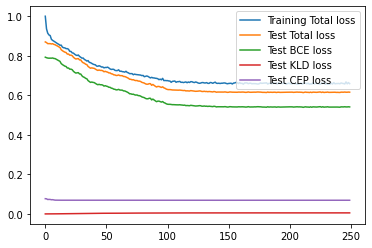

<Figure size 432x288 with 0 Axes>

In [15]:
obj1.plot_residuals(init_index=0)

# Load Model and Data

In [16]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
#import umap
import pickle
import matplotlib.pyplot as plt

In [17]:
print("start of the code")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############################################################   
##############################################################
model_init=True
model_tobe_trained=False

model_init=True
model_file_address='./bb.pt'
save_address1="./"

df_XY=pd.read_csv('df_XY.csv')

start of the code


## Load Saved Model

In [20]:
obj2 = ivae.IVAE(df_XY = df_XY,
               reconst_coef = reconst_coef,
               latent_size = 10,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

obj2.model_initialiaze()

obj2.model_load(address="bb.pt")

## Print the Weights

In [21]:
for param in obj2.model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0155,  0.1019, -0.0324, -0.0207,  0.3712],
        [ 0.0554,  0.3167,  0.2738, -0.2131, -0.2541],
        [ 0.1391, -0.0379, -0.0697,  0.5671,  0.1832],
        [-0.2832,  0.3884,  0.3305,  0.2895,  0.4208],
        [-0.1114, -0.3216,  0.1055, -0.0972,  0.1871],
        [ 0.3036,  0.4402,  0.0748,  0.1447, -0.2154],
        [ 0.1178, -0.3803,  0.0624, -0.0521, -0.2992],
        [ 0.2434, -0.4074,  0.1455, -0.3698,  0.0199],
        [ 0.3827,  0.0347, -0.2962,  0.4424,  0.0400],
        [ 0.1899,  0.1763,  0.0239,  0.4662,  0.1351],
        [ 0.4213,  0.2268, -0.1542, -0.0675,  0.2199],
        [-0.2024, -0.0701, -0.2209,  0.4568, -0.2427],
        [ 0.1540, -0.1161, -0.3095,  0.0918, -0.4462],
        [-0.1807, -0.2961, -0.2772,  0.2066,  0.1174],
        [ 0.2022, -0.0343,  0.0716,  0.1548,  0.5143],
        [ 0.3442,  0.2070,  0.3629,  0.5374, -0.1946],
        [-0.1881,  0.0641, -0.2297, -0.0685,  0.5897],
        [ 0.5352, -0.0050,  0.0885, -0.2583

# Make Prediction of All Test Data

In [22]:
with torch.no_grad():
    obj2.model.eval()

    #obj1.load_residuals(address='bb_residuals.pkl')
    print("model loaded")
    
    obj2.generate_test_results()
    print("test data generated")

model loaded
test data generated


# Comprehensive Checking of The Prediction Values vs. True Values. 

In [23]:
print(obj2.x_last)

tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [-1.9519,  2.4412, -0.0173,  0.9123,  1.2397],
        [-0.5734,  0.4249, -0.2713, -0.6836, -1.5374],
        [-0.1014,  0.7467,  0.9292,  0.2294,  0.4144]])


In [24]:
print(obj2.x_pred)

tensor([[ 0.1172,  0.9667,  0.7347,  1.6802,  0.9620],
        [-0.3261, -0.0919, -0.0794,  0.0088,  0.7322],
        [-0.1200,  0.5585,  0.4476,  0.4416,  0.8562],
        ...,
        [-0.0878,  0.6471,  0.5311,  0.5500,  0.8537],
        [-0.1267, -0.0641,  0.0474, -0.4015, -0.8813],
        [-0.1524,  0.4272,  0.4688,  0.6176,  0.6871]])


In [25]:
(np.abs(obj2.x_pred - obj2.x_last)).mean()

tensor(0.5409)

In [26]:
(obj2.x_pred-obj2.x_last)

tensor([[-1.6468,  0.5665, -0.2440, -0.5607, -0.9055],
        [ 0.6512, -1.0420,  0.0719,  0.1120,  0.3216],
        [-0.2640, -0.8958, -0.3134,  0.3199,  0.4123],
        ...,
        [ 1.8641, -1.7941,  0.5484, -0.3623, -0.3860],
        [ 0.4467, -0.4890,  0.3186,  0.2821,  0.6561],
        [-0.0510, -0.3195, -0.4604,  0.3882,  0.2727]])

In [27]:
print(obj2.y_last)

tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [28]:
print(obj2.y_pred)

tensor([[-0.0387, -0.0629],
        [-0.0068, -0.0040],
        [-0.0172, -0.0073],
        ...,
        [-0.0260,  0.0054],
        [ 0.0305, -0.0008],
        [-0.0305, -0.0363]])


In [29]:
df_XY

,A,B,C,D,E,Y,YY
0,1.764052,0.400157,0.978738,2.240893,1.867558,1,1
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,0,0
2,0.144044,1.454274,0.761038,0.121675,0.443863,0,0
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1,0
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0,1
...,...,...,...,...,...,...,...
995,1.711489,-1.820816,0.163495,-0.813117,-0.605355,0,0
996,-1.327524,-0.644172,1.908883,-0.563545,1.082473,1,0
997,-1.951911,2.441216,-0.017285,0.912282,1.239658,1,1
998,-0.573367,0.424889,-0.271260,-0.683568,-1.537438,1,1


In [30]:
with torch.no_grad():
    obj2.model.eval()
    for x, y in obj2.testloader:
      x = x.to(device)
      print(x.size())
      print(x)
      # forward
      x_hat,y_hat, mu, logvar,z = obj2.model(x)
    
    df_reconstructed = pd.DataFrame(x_hat.cpu().detach().numpy(), columns=obj1.df_XY.drop(columns=['Y']).columns)
    print(df_reconstructed.shape)
    df_latent=pd.DataFrame(z.cpu().detach().numpy())
    
    obj2.model.eval()
    
    df_reconstructed_decoder=pd.DataFrame(obj2.model.decoder(z).cpu().detach().numpy(), columns=obj1.df_XY.drop(columns=['Y']).columns)

    df_reconstructed.to_csv('df_reconstructed.csv')
    df_latent.to_csv('df_latent.csv')
    df_reconstructed_decoder.to_csv('df_reconstructed_decoder.csv')
    print("Full_data_reconstructed...")
    
    print("========df_reconstructed========")
    print(df_reconstructed)
    print("========df_reconstructed_decoder========")
    print(df_reconstructed_decoder)
    print("========df_Original========")
    print(df_XY)
    
    
    


torch.Size([1000, 5])
tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [-1.9519,  2.4412, -0.0173,  0.9123,  1.2397],
        [-0.5734,  0.4249, -0.2713, -0.6836, -1.5374],
        [-0.1014,  0.7467,  0.9292,  0.2294,  0.4144]])
(1000, 5)
Full_data_reconstructed...
========df_reconstructed========
            A         B         C         D         E
0    0.351372  0.865062  0.624223  1.941547  0.782118
1   -0.382521 -0.169283 -0.168879 -0.227918  0.735888
2   -0.143557  0.513098  0.392422  0.376914  0.876138
3    0.254413  0.097964  0.114112  0.045557 -1.162482
4   -0.144946  0.545727 -0.224350 -0.687987  1.690156
..        ...       ...       ...       ...       ...
995 -0.029707  0.172607  0.231951 -1.074538 -0.322066
996 -0.377260 -0.136964 -0.176268 -0.431910  0.793489
997 -0.093372  0.669241  0.574006  0.667202  0.842162
998  0.121768  0.182474 

# Checking Linear Separability of Data on Lower Dimensioanl Space

In [32]:
print("regression analysis")
obj2.regression_analysis(obj2.zs,df_XY['Y'])

regression analysis
0.538


# Visualize Data on Lower Dimensional Space

In [ ]:
print("calculate tsne_umap_pca")
tsne_mat,umap_mat,pca_mat,Y=obj2.calculate_lower_dimensions(obj2.zs,obj2.y_last,N=100)
obj2.plot_lower_dimension(tsne_mat,Y,projection='3d',save_str='tsne3d.pdf')
obj2.plot_lower_dimension(tsne_mat,Y,projection='2d',save_str='tsne2d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='3d',save_str='umap3d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='2d',save_str='umap2d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='3d',save_str='pca3d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='2d',save_str='pca2d.pdf')

print("finished")


calculate tsne_umap_pca


# Perform Interpolation across all groups (Y) and all features from YY=0 to YY=1

In [ ]:
ff = obj2.traversal_all_groups(traversal_step=5)

# See the interpolation results

In [ ]:
with open('results_dict.pkl', 'rb') as f:
    ff = pickle.load(f)

In [ ]:
ff['med']['0']

In [ ]:
ff['mean']['1']

In [ ]:
plt.plot(ff['med']['1']['B'])

In [ ]:
plt.plot(ff['mean']['1']['B'])

In [ ]:
plt.plot(ff['med']['0']['C'])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ff['mean']['0']['C'])

# Generate Synthetic Data for a Given Class

In [ ]:
bb = obj2.synthetic_single_group(group_id=0,nr_of_synthetic=1000)

In [ ]:
bb.shape

In [ ]:
bb